## Demo of changing face on Misty I via rerobots API

This is free software, released under the Apache License, Version 2.0.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

To learn more about our services, go to https://help.rerobots.net/

Copyright (c) 2018 rerobots, Inc.

In [1]:
API_TOKEN = ''  # GET YOUR TOKEN FROM https://rerobots.net/tokens

In [ ]:
!pip install rerobots
!pip install paramiko

In [3]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
from rerobots.api import Instance


instance = Instance(['fixed_misty1devel'], api_token=API_TOKEN)

In [5]:
## Wait for instance to finish initializing

while True:
    if instance.get_status() == 'READY':
        break
    time.sleep(2)

In [6]:
instance.get_details()

{'conn': {'hostkeys': ['ecdsa-sha2-nistp256 AAAAE2VjZHNhLXNoYTItbmlzdHAyNTYAAAAIbmlzdHAyNTYAAABBBMWqGbR5J5jySPrK3ievwN4OHh4cxVXqOLKaS/HGYYo82gZjM9CFNbH28wVdO20Xlol3zNfA9sWRKR8m98+yVf0= root@rrc'],
  'ipv4': '147.75.69.207',
  'port': 2210,
  'type': 'sshtun'},
 'region': 'us:cali',
 'starttime': '2018-11-11 01:50:48.721188',
 'status': 'READY',
 'type': 'fixed_misty1devel'}

In [7]:
## Start the "cam" add-on, which supports video streaming

while True:
    payload = instance.status_addon_cam()
    if payload['status'] == 'active':
        break
    elif payload['status'] == 'notfound':
        instance.activate_addon_cam()
    time.sleep(2)


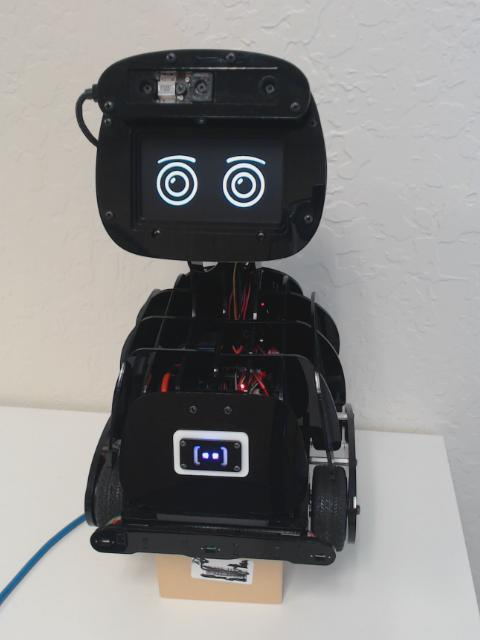

In [8]:
## Display the Misty I Developers' Edition robot as it is now.
## The image is displayed as an HTML <img> element
## in this Jupyter Notebook.
from IPython.display import display, HTML

payload = instance.get_snapshot_cam(coding='base64', format='jpeg')

if not payload['success']:
    time.sleep(1)
    payload = instance.get_snapshot_cam(coding='base64', format='jpeg')
    assert payload['success']

display(HTML('<img src="data:image/jpeg;base64,{}">'.format(payload['data'])))

In [140]:
## Setup ssh

instance.start_sshclient()

In [141]:
## Change facial expression
res = instance.exec_ssh('curl -X POST -d \'{"FileName": "Happy.jpg"}\'  http://10.34.54.1/api/images/change')
time.sleep(1)
str(res, encoding='utf-8')


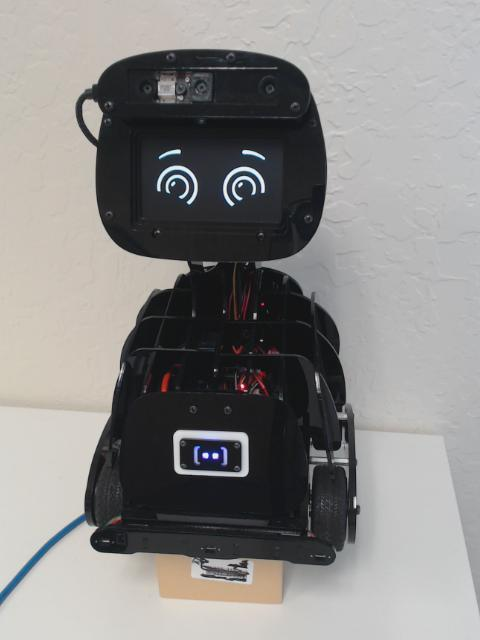

In [142]:
## Display the Misty I Developers' Edition robot as it is now
## The image is displayed as an HTML <img> element
## in this Jupyter Notebook.
from IPython.display import display, HTML

payload = instance.get_snapshot_cam(coding='base64', format='jpeg')
display(HTML('<img src="data:image/jpeg;base64,{}">'.format(payload['data'])))

In [9]:
## Tilt head down
res = instance.exec_ssh('curl -X POST -d \'{"Axis": "pitch", "position": 4, "velocity": 3}\'  http://10.34.54.1/api/beta/head/position')
time.sleep(1)
str(res, encoding='utf-8')

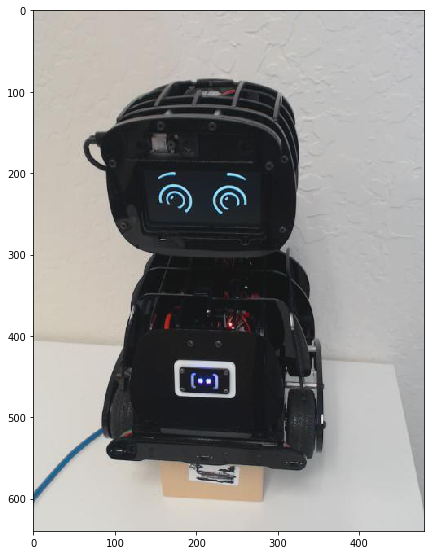

In [144]:
## Display the Misty I Developers' Edition robot as it is now
## The image is represented as type NumPy ndarray and
## displayed by Matplotlib.

payload = instance.get_snapshot_cam(format='ndarray')
fig = plt.figure(figsize=(7,12))
plt.imshow(payload['data'])

In [ ]:
# Done!

instance.terminate()